## Chapter 04. Semantic Analysis

In [1]:
# !wget -c https://github.com/euphoris/datasets/raw/master/neurips.zip

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
import pandas as pd
# 학회에서 발표된 논문의 초록 데이터
df = pd.read_csv('./data/neurips.zip')
df.head()

,year,title,abstract
0,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
1,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
2,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...
3,2007,Simplified Rules and Theoretical Analysis for ...,We show that under suitable assumptions (prima...
4,2007,Predicting human gaze using low-level saliency...,"Under natural viewing conditions, human observ..."


In [5]:
df.tail()

,year,title,abstract
3915,2017,"On Separability of Loss Functions, and Revisit...",We revisit the classical analysis of generativ...
3916,2017,Maxing and Ranking with Few Assumptions,PAC maximum ...
3917,2017,On clustering network-valued data,"Community detection, which focuses on clusteri..."
3918,2017,A General Framework for Robust Interactive Lea...,We propose a general framework for interactive...
3919,2017,Multi-view Matrix Factorization for Linear Dyn...,We consider maximum likelihood estimation of l...


In [6]:
# 문서 단어 행렬로 만듦
# CountVectorizer와 TfidVectorizer 는 두 가지 사용 후 결과를 보고 사용
# 전자의 경우, 자주 나오는 단어에 비중을 많이 반영할 수 있는데, 후자는 여러 문서에서 공통적으로 자주 나오는 단어는 상대적으로 덜 반영
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = TfidfVectorizer(stop_words='english', max_features=2000)
x = cv.fit_transform(df.abstract)
# 단어 목록을 변수에 지정
words = cv.get_feature_names_out()

### LSA Practice, SVD

In [7]:
from sklearn.decomposition import TruncatedSVD
x.shape

(3920, 2000)

In [9]:
# 초기화, n_componets = 몇 개의 차원으로 줄일 것인가 결정, 3920개의 문서, 2000개의 단어 갯수 有
svd = TruncatedSVD(n_components=100, random_state=2023)

In [10]:
# fit = 분석의 과정, transform = 분석 결과를 바탕으로 변환을 해 새로운 결과물을 창출
# 원래 문서를 100차원으로 표현하고, 100차원이 기존 차원과 혹은 차원과 문서가 혹은 차원과 단어가 어떤 관계가 있는가로 분해
svd.fit(x)

TruncatedSVD(n_components=100, random_state=2023)

In [11]:
# 주제의 값이 변화할 때 단어의 값이 어떻게 변화하는가 표현
svd.components_ # 차원과 단어의 관계 저장됨

array([[ 0.00483864,  0.01243762,  0.004755  , ...,  0.00491457,
         0.0162017 ,  0.01160996],
       [-0.00554029, -0.01860005, -0.00681509, ...,  0.00074321,
         0.00149551,  0.00839813],
       [-0.00331542, -0.02285971, -0.00537674, ..., -0.00103513,
         0.0013572 , -0.00786359],
       ...,
       [ 0.00276808,  0.0071889 ,  0.00645267, ..., -0.0021116 ,
         0.00145271, -0.02437214],
       [ 0.00260051,  0.01569788,  0.0035576 , ..., -0.00306548,
         0.00705056, -0.01528164],
       [ 0.00472228,  0.02385804, -0.00066134, ..., -0.00816752,
         0.00820668, -0.01110316]])

In [15]:
# index 함수를 통해 특정 단어가 몇 번째 위치에 있는지 확인
word_idx = list(words).index('topic')

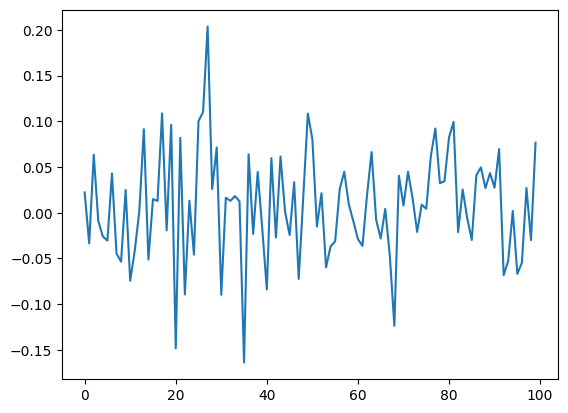

In [16]:
# 행이 주제에 해당하므로 : 을 통해 모든 주제를 가져오고, 열은 지정한 열만 가져옴
# 주제마다 해당 단어와 관련도가 높은지 낮은지 확인 가능
from matplotlib import pyplot
pyplot.plot(svd.components_[:, word_idx])

In [17]:
# argmax 함수를 통해 가장 큰 값이 있는 위치를 파악
topic_idx = svd.components_[:, word_idx].argmax()
topic_idx

27

In [18]:
# 가장 관련이 큰 주제가 다른 단어들하고 얼마나 관련이 있는지 확인
# loading = 주제와 단어의 관련도
topic = pd.DataFrame({'word': words, 'loading': svd.components_[topic_idx]})
topic.sort_values('loading').tail()

,word,loading
1202,norm,0.116061
804,graph,0.122245
866,image,0.155788
1861,topic,0.203669
1713,sparse,0.209761


### 병렬 분석

In [ ]:
# 임의의 차원이 어느 정도가 적당한지 판단
# 주제의 수를 몇 차원으로 줄일 것 인가?
# 원래 X 와 비슷하게 생긴 데이터를 랜덤하게 만들어서 똑같은 SVD 로 처리하여, 랜덤한 것을 줄인 차원보다 나아지는 지점까지만 차원 축소를 진행

In [19]:
import numpy as np
x.shape

(3920, 2000)

In [20]:
# x.shape 을 통해 원래 데이터의 행과 열을 지정
nrow, ncol = x.shape

In [21]:
def resample(a):
    return np.random.choice(a, size=nrow)

np.random.seed(2999)
d = np.apply_along_axis(resample, 0, x.A)
# x 를 열마다 적용해 새롭게 섞어서 새로운 결과물 생성
# 단어와 단어의 관계가 없어짐

# a에서 랜덤하게 원래의 row만큼 데이터를 형성
# 기존 단어의 분포와 동일한 분포를 갖는 데이터를 생성

In [22]:
d.shape

(3920, 2000)

In [23]:
svd2 = TruncatedSVD(n_components=100, random_state=1234)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=1234)

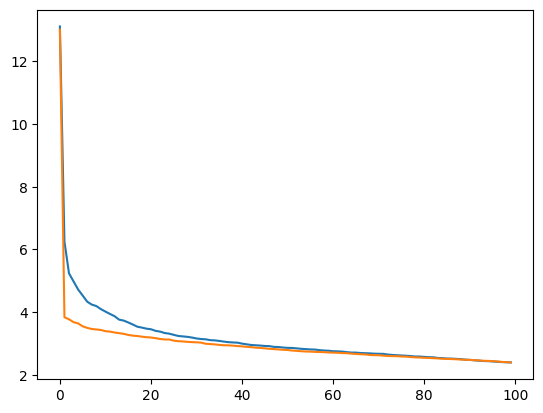

In [24]:
# 차원이 뒤로 갈수록, 중요성이 떨어짐
pyplot.plot(svd.singular_values_)
pyplot.plot(svd2.singular_values_)

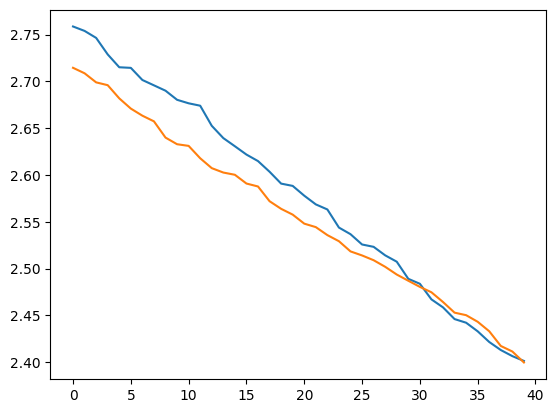

In [25]:
# SVD2가 SVD를 넘어가는 지점이 원본 데이터가 망가진 데이터의 설명력과 비슷하다고 볼 수 있기 때문에, 만나는 지점 이후 차원은 무시 결정
pyplot.plot(svd.singular_values_[60:])
pyplot.plot(svd2.singular_values_[60:])

In [26]:
# 분해를 통해 나온 singular value를 서로 비교
# 91차원까지만 필요함을 결정
# SVD 를 다시 처리하거나 91번 이후를 무시하면 됨
np.argwhere(svd.singular_values_ - svd2.singular_values_ <= 0)[0]

array([91], dtype=int64)

In [27]:
svd.components_.shape

(100, 2000)

### 회전과 결과 해석

In [ ]:
# !pip install factor_analyzer

In [28]:
# 회전을 통해 단어의 주제를 집중시켜, 해석을 용이하게 만들어줌
from factor_analyzer.rotator import Rotator
rotator = Rotator()
# 모형 초기화, method를 변경하면 다른 종류의 회전을 할 수 있고, default는 VARIMAX

In [29]:
# 기존엔 행이 주제, 열이 단어이므로 T를 통해 행과 열을 뒤집어줌
# 단어가 행 방향, 주제가 열 방향
rot = rotator.fit_transform(svd.components_.T)

In [30]:
# 회전된 결과가 출력
loading = rot.T

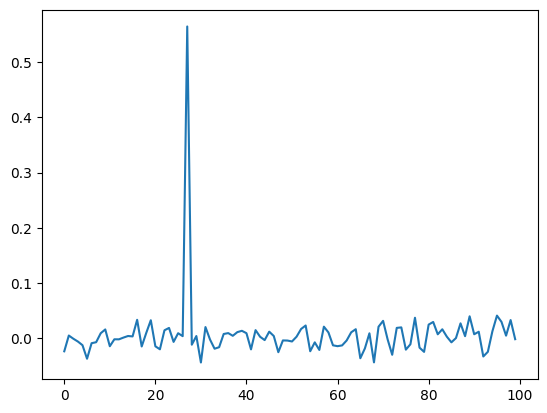

In [31]:
word_idx = list(words).index('topic')
pyplot.plot(loading[:, word_idx])

In [32]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

27

In [33]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail()

,word,loading
1988,words,0.204857
1003,lda,0.223883
541,documents,0.230872
1862,topics,0.279968
1861,topic,0.564518


In [37]:
# fit과 분리하여 transform을 통해 변경된 결과 출력
doc_topics = svd.transform(x)
doc_topics

array([[ 8.26281390e-02,  7.63575077e-02, -4.10862905e-02, ...,
         2.16611047e-03, -8.44702735e-03,  4.72866605e-03],
       [ 2.74179474e-01,  2.53730551e-02,  1.25860050e-01, ...,
        -4.04286134e-02,  4.93199120e-02, -3.17715165e-02],
       [ 1.96016274e-01,  1.97296041e-04, -1.11450481e-01, ...,
         2.04675407e-03, -1.63896993e-02, -5.22915678e-02],
       ...,
       [ 1.90719150e-01, -8.92628600e-02, -3.90951180e-02, ...,
         2.17818081e-02, -6.69945489e-02, -1.55076450e-02],
       [ 2.64942038e-01, -1.08482548e-02,  1.83506488e-03, ...,
        -6.63037582e-02, -3.97023893e-02,  6.97669040e-02],
       [ 2.22241450e-01,  1.31263997e-02,  1.06525634e-01, ...,
         2.07369768e-02,  3.66883806e-02,  9.95714454e-03]])

In [39]:
rotator.rotation_

array([[ 0.11821514, -0.12883668,  0.10230123, ...,  0.05640551,
        -0.07336662, -0.18369435],
       [-0.04126782,  0.30185989, -0.0744475 , ...,  0.0979624 ,
         0.15747093, -0.06014892],
       [ 0.02785582,  0.31320091,  0.19923522, ..., -0.00268231,
         0.06377568, -0.05154396],
       ...,
       [-0.05166245, -0.07559889, -0.04342789, ...,  0.00879448,
         0.02129673,  0.14114325],
       [-0.06500935, -0.07406495, -0.01018473, ...,  0.03033983,
         0.34115317, -0.04876361],
       [-0.23894023,  0.01308267, -0.09127264, ...,  0.04305605,
        -0.01091798,  0.20347564]])

In [38]:
# 회전을 적용 @는 행렬곱을 뜻하므로, 회전행렬과 곱해주면 회전된 결과가 나옴
doc_topics = doc_topics @ rotator.rotation_
doc_topics

array([[ 0.0360766 ,  0.00905575, -0.01339002, ..., -0.04827475,
         0.00500471, -0.0204132 ],
       [ 0.09357187,  0.02853752,  0.06480624, ...,  0.04990124,
        -0.00212975, -0.08723358],
       [ 0.07820995,  0.01736257,  0.00548414, ..., -0.01621252,
        -0.00947724,  0.00234196],
       ...,
       [ 0.08963851, -0.07227814,  0.00854602, ...,  0.02275253,
        -0.06493354, -0.04655541],
       [-0.01661822, -0.01500463,  0.00571189, ...,  0.03981285,
        -0.00886964, -0.0052792 ],
       [ 0.07942817,  0.01322949,  0.01361739, ..., -0.08536871,
         0.0171227 , -0.04097717]])

In [42]:
# 문서별로 해당 단어를 얼마나 포함하고 있는지 출력
year_topic = pd.DataFrame({'year': df.year, 'topic': doc_topics[:, topic_idx]})
year_topic

,year,topic
0,2007,0.043532
1,2007,-0.029858
2,2007,-0.007893
3,2007,0.024463
4,2007,0.026717
...,...,...
3915,2017,0.000868
3916,2017,0.022867
3917,2017,0.001363
3918,2017,-0.015118


In [43]:
year_topic.groupby('year').agg('mean')

,topic
year,
2007,0.026259
2008,0.015054
2009,0.019185
2010,0.014327
2011,0.011568
2012,0.018776
2013,0.017173
2014,0.014626
2015,0.008761


### NMF Practice

In [44]:
# SVD 와 달리 음수가 아닌 결과만 보여주므로, 해석이 편하다 (음수의 경우, 해석이 어려움)
# NMF는 차원에 따라 결과가 달라지므로, SVD에서 확인한 차원의 수를 입력 (SVD는 차원의 갯수가 결과에 영향을 끼치지 않고, 자의적으로 끊어서 보면 됨)

from sklearn.decomposition import NMF
nmf = NMF(n_components=89, random_state=2023)
doc_topics = nmf.fit_transform(x)

c:\Users\lucky\anaconda3\envs\TEST\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [45]:
loading = nmf.components_

In [46]:
# topic 이란 단어가 몇 번인가?
word_idx = list(words).index('topic')

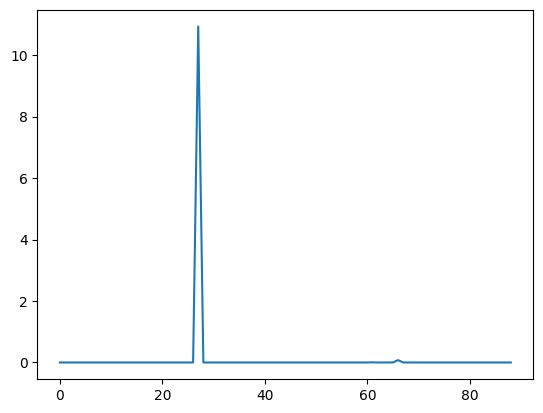

In [47]:
# 어떤 주제랑 관련 있는가, 회전을 하지 않아도 회전 결과처럼 출력 (회전을 진행하면, Non-negative가 깨지므로 진행하면 안 됨)
pyplot.plot(loading[:, word_idx])

In [48]:
# 몇 번째 주제인가 확인
topic_idx = loading[:, word_idx].argmax()
topic_idx

27

In [49]:
# 27번 주제가 어떤 단어랑 관련있는지 확인
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
1138,modeling,1.096346
1842,text,1.541268
64,allocation,1.860067
1988,words,2.331399
540,document,2.749544
520,dirichlet,2.998344
541,documents,3.665230
1003,lda,3.920461
1862,topics,5.312519
1861,topic,10.933892


In [50]:
# 연도별 변화 확인
year_topic = pd.DataFrame({'year': df.year, 'topic': doc_topics[:, topic_idx]})
year_topic.groupby('year').agg('mean')

,topic
year,
2007,0.001180
2008,0.000688
2009,0.000939
2010,0.000641
2011,0.000642
2012,0.000888
2013,0.000681
2014,0.000640
2015,0.000440


### LDA Practice with gensim

#### 문서 단어 행렬을 Corpus 형식으로 변환

In [1]:
import pandas as pd
df = pd.read_csv('./data/neurips.zip')
df.head()

,year,title,abstract
0,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
1,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
2,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...
3,2007,Simplified Rules and Theoretical Analysis for ...,We show that under suitable assumptions (prima...
4,2007,Predicting human gaze using low-level saliency...,"Under natural viewing conditions, human observ..."


In [2]:
# sklearn 함수를 이용한 전처리 (문서 단어 행렬 만들기)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 각 문서의 초록을 문서 단어 행렬로 변환
cv = TfidfVectorizer(stop_words='english', max_features=2000)
x = cv.fit_transform(df.abstract)

# 추출한 단어를 리스트로 저장
words = cv.get_feature_names_out()

In [ ]:
# !pip install gensim==4.1.2
# !pip uninstall smart_open
# !pip install smart_open==5.2.1

In [4]:
from gensim.matutils import Sparse2Corpus
# x.T = x의 행과 열을 변환하여 함수에 지정해주면  gensim에서 사용하는 corpus 형태로 변환
corpus = Sparse2Corpus(x.T)

# 단어와 문서 내 단어의 빈도
corpus[0]

[(1209, 0.19719051171057086),
 (1250, 0.1878641742740461),
 (265, 0.11655716303382495),
 (495, 0.21779310927686704),
 (316, 0.16096846113531893),
 (321, 0.25275451313424946),
 (317, 0.3778227141887415),
 (1573, 0.35429796717697476),
 (650, 0.32556474378711336),
 (1346, 0.3395230603787923),
 (1759, 0.32398854042493375),
 (767, 0.18302469761238765),
 (1756, 0.1205808084872785),
 (1219, 0.2021297737105109),
 (1282, 0.1848866146903614),
 (984, 0.2396176930939823)]

In [7]:
# enumerate = 단어별로 번호를 붙혀줌
id2token = dict(enumerate(words))
id2token[9]

'abstract'

#### Corpus 형식으로 바로 변환

In [8]:
# sklearn 버젼에 따라 Module Not Found Error가 발생할 수 있다, 이럴 때 stop_words 앞에 밑줄을 추가하여 써준다
import re
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

# import re
# from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [9]:
# 토큰화 함수를 만든다
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)
# 토크나이저 함수를 정규표현식으로 특정한 패턴을 추출
# \w = 일반적으로 단어에 사용되는 문자 {2,} : 두 글자 이상, \b : 단어 경계
# 단어 경계에서 경계까지 두 글자 이상이 있는 경우, 추출
# re.UNICODE를 통해 영어뿐만 아니라 한글도 추출
def tokenizer(text):
    text = text.lower() # 텍스트를 소문자 변환
    words = []          # 단어 리스트 생성
    for word in token_re.findall(text):
        if word not in ENGLISH_STOP_WORDS:
            words.append(word)
    return words

In [10]:
# 문서를 토큰화 한다
docs = []
for text in df.abstract:
    doc = tokenizer(text)
    docs.append(doc)
docs

[['known',
  'determinining',
  'dec',
  'pomdp',
  'cooperative',
  'partially',
  'observable',
  'stochastic',
  'game',
  'posg',
  'cooperative',
  'strategy',
  'positive',
  'expected',
  'reward',
  'complete',
  'nexp',
  'known',
  'cooperation',
  'affected',
  'complexity',
  'competitive',
  'posgs',
  'complexity',
  'determining',
  'team',
  'positive',
  'expected',
  'reward',
  'strategy',
  'complete',
  'class',
  'nexp',
  'oracle',
  'np'],
 ['present',
  'truly',
  'polynomial',
  'algorithm',
  'learning',
  'structure',
  'bounded',
  'treewidth',
  'junction',
  'trees',
  'attractive',
  'subclass',
  'probabilistic',
  'graphical',
  'models',
  'permits',
  'compact',
  'representation',
  'probability',
  'distributions',
  'efficient',
  'exact',
  'inference',
  'constant',
  'treewidth',
  'algorithm',
  'polynomial',
  'time',
  'sample',
  'complexity',
  'provides',
  'strong',
  'theoretical',
  'guarantees',
  'terms',
  'kl',
  'divergence',
  't

In [11]:
# 사전을 만든다
from gensim.corpora.dictionary import Dictionary

# Dictionary엔 docs의 모든 단어 기재
dic = Dictionary(docs)

# 10개 미만의 문서에만 나왔거나, 또는 90% 이상의 문서에서 나온 단어는 제외한다
dic.filter_extremes(no_below=10, no_above=0.9)
# n_most_frequent: 가장 자주 나오는 단어 기준으로 자름
# extremes : 극단적인 단어 기준으로 자름

dic[100] # 'existing'

# 토큰화된 문서를 gensim에서 사용하는 형식으로 변환한다.
corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
# 리스트를 만든 뒤, 토큰화되어 있는 문서들을 변환함

dic[0] # 'affected'
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 2),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 2),
 (17, 1),
 (18, 2)]

#### LDA Practice

In [14]:
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import train_test_split
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.1, random_state=2023)
# 데이터 분할: LDA 모델에서 추정의 시점을 정하기 위해

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
# 모형을 설정한다
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=2023)

In [19]:
loss = model.log_perplexity(valid_corpus) #모델 성능 측정
loss # 앞에 -를 붙히면 교차 엔트로피가 됨, 숫자가 커질수록 좋음 (0에 가까울수록 좋음)

-19.935556247056002

In [20]:
import numpy
old_loss = -numpy.inf
while loss > old_loss + 0.1: #loss가 일정한 값보다 크면 반복, 커지지 않으면 반복 X
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus) # 다른 지표로도 학습할 수 있음 (현재; 혼란도)
    print(loss)

-18.13463585005185
-17.09490780164132
-16.521297887439918
-16.186729273861197
-15.976582150413693
-15.835591002235581
-15.732424834504332
-15.651936585957532


In [21]:
# 저장
model.save('lda-model')

In [22]:
!zip mylda.zip lda-model* # lda-model로 시작하는 모든 파일을 찾아 mylda로 압축
# 다음 분석 시 압축 풀고, lda-model을 호출해서 사용 가능

'zip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [23]:
# 불러오기
model = LdaModel.load('lda-model')

#### LDA Result

In [24]:
# 번호를 통해, 해당 토픽의 자주 나오는 단어와 확률을 보여줌
model.show_topic(0)

[('image', 0.05587036),
 ('images', 0.021355698),
 ('network', 0.019981273),
 ('model', 0.018687295),
 ('segmentation', 0.018370403),
 ('networks', 0.015939558),
 ('neural', 0.015162048),
 ('convolutional', 0.015086872),
 ('scene', 0.014258865),
 ('state', 0.009976499)]

In [25]:
# 사전에서 원하는 단어를 검색해 번호 확인
dic.token2id['topic']

307

In [26]:
# 307번 단어가 어느 토픽에서 많이 나오는가 확인 (0.01 = 307번 단어가 1% 이상 나오는 topic을 호출)
model.get_term_topics(307, 0.01)

[(2, 0.08669962)]

In [27]:
model.show_topic(8)

[('exponential', 0.06317836),
 ('family', 0.044671815),
 ('data', 0.025972292),
 ('embedding', 0.016521078),
 ('face', 0.01418845),
 ('personalized', 0.01274753),
 ('person', 0.011857821),
 ('applications', 0.010845583),
 ('families', 0.010052123),
 ('large', 0.009769166)]

In [28]:
new_text = '''We describe latent Dirichlet allocation (LDA), a generative probabilistic model for collections of
discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in
turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of
text modeling, the topic probabilities provide an explicit representation of a document. We present
efficient approximate inference techniques based on variational methods and an EM algorithm for
empirical Bayes parameter estimation. We report results in document modeling, text classification,
and collaborative filtering, comparing to a mixture of unigrams model and the probabilistic LSI
model.'''
# 여러 줄로 된 텍스트를 사용할 땐 '''를 씀

In [29]:
# 토큰화 한 뒤, 사전에 나오는 단어의 갯수를 세, corpus 형식으로 변환
doc = tokenizer(new_text)
bow = dic.doc2bow(doc)

In [30]:
# LDA 관련된 논문이 LDA 관련 주제로 출력되는 올바른 결과 (8번 topic)
model.get_document_topics(bow)

[(2, 0.19614823),
 (8, 0.018628543),
 (22, 0.19086447),
 (46, 0.051582605),
 (47, 0.05480916),
 (51, 0.11548277),
 (56, 0.031282227),
 (78, 0.050346155),
 (80, 0.023200085),
 (83, 0.16938879),
 (90, 0.08572994)]

#### Visualization with LDAvis

In [ ]:
# !pip install pyLDAvis==2.1.2 # 신버전과는 충돌이 있으므로, 강제로 구버전 설치

In [31]:
import pyLDAvis.gensim
# topic의 내용을 수치가 아닌 시각적으로 확인
pyLDAvis.enable_notebook()

In [ ]:
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)

In [ ]:
# 100개의 topic이 비슷한 주제(단어 사용 빈도)가 가까이에 그려지도록 분포
# topic 번호가 앞의 수치화보다 하나씩 밀려있음
# 0 하면 전반적인 수치를 보여줌
# 관련도 계산 수치를 조절하면, 1 쪽으로 미룰 시, 토픽에서 가장 많이 나오는 단어 기준으로 계산 (1)
# 0으로 미룰 시, 평소에 그 단어가 나오는 비율 대비 해당 토픽에서 얼마나 많이 나오는가?
# 해당 토픽에서 절대적으로 많이 나오지 않지만, 상대적으로 해당 토픽에서 많이 나온다 (0)
# 보통 0.6 정도를 권장
pyLDAvis.display(p)

In [33]:
# 응집도와 다양도 계산
from gensim.models import CoherenceModel
coh = CoherenceModel(model=model, corpus=corpus, texts=docs, dictionary=dic, coherence='c_v')
coh.get_coherence()
# 주제의 수를 바꿔가며 응집도를 구해 비교해볼 수 있음

0.3645160663422768

In [34]:
# 다양도 확인 (손으로 직접 계산)
topn = 25 # 토픽별 상위 25개 단어 추출
top_words = set() # set()은 원소를 추가할 때, 중복되는 원소는 추가하지 않을 수 있음

for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)

In [35]:
len(top_words) # 각 주제별로 상위 25개 단어가 모여있는 집합

1080

In [36]:
1072 / 2500

0.4288